In [1]:
import os
import pyproj
import pandas as pd
import networkx as nx
from shapely import Polygon
import matplotlib.pyplot as plt
from shapely.ops import transform
import geopandas as gpd

os.chdir('..')
from scripts.Graph_func import load_city_graph, graph_to_dataframe, load_city_amenities

In [28]:
G = load_city_graph(city = f"Oslo", osm_type = 'public_streets', stage = 'deep_clean')

In [ ]:
get_stats_dict(G, 'Oslo', 'public_streets_new', 'deep_clean')

In [29]:
#G.remove_edges_from(nx.selfloop_edges(G))
#len(list(nx.selfloop_edges(G)))

In [35]:
len([n for n in G.nodes if len(list(G.neighbors(n))) == 1])

270

# Get stats

In [39]:
def get_stats_dict(G, city, t, stage):
    stats_dict = {}
    #Add city, type and stage
    stats_dict['City'] = city
    stats_dict['Type'] = t
    stats_dict['Stage'] = stage

    #Basic stats
    stats_dict['#Nodes'] = len(G.nodes)
    stats_dict['#Edges'] = len(G.edges)

    #Component stats
    components = nx.connected_components(G)
    components = [i for i in list(components)]
    component_sizes = [len(i) for i in components]
    component_sizes.sort(reverse= True)
    isolated_nodes = nx.isolates(G)
    stats_dict['#Components'] = len(component_sizes)
    stats_dict['Max size'] = max(component_sizes)
    stats_dict['Min size'] = min(component_sizes)
    stats_dict['Isolated nodes'] = len(list(isolated_nodes))

    return stats_dict

In [40]:
stats = [] #List of dicts for stats
for city in ['Bergen', 'Oslo', 'Portland', 'Trondheim', 'Washington D.C']:
    for osm_type in ['public_streets', 'bike']:
        for stage in ['raw', 'clean', 'deep_clean']:
            if stage == 'raw':
                G = load_city_graph(city = city, osm_type = osm_type, stage = 'raw')
                stats.append(get_stats_dict(G, city = city, t=osm_type, stage = 'Raw'))
            elif stage == 'clean':
                G = load_city_graph(city = city, osm_type = osm_type, stage = 'clean')
                stats.append(get_stats_dict(G, city = city, t=osm_type, stage = 'Pruning'))
            elif stage == 'deep_clean' and osm_type != 'public_transport':
                G = load_city_graph(city = f"{city}", osm_type = osm_type, stage = 'deep_clean')
                stats.append(get_stats_dict(G, city = city, t=osm_type, stage = 'Connectivity'))

In [41]:
pd.DataFrame(stats).to_csv('stats.csv')

# Check for planrity

In [ ]:
stats = [] #List of dicts for stats
for city in ['Oslo', 'Bergen', 'Portland', 'Trondheim', 'Washington D.C']:
    G = load_city_graph(city = f"{city}", osm_type = 'public_streets', stage = 'deep_clean')                
    p = nx.algorithms.planarity.is_planar(G)
    print(f"{city} is {'' if p else 'not'} planar")

Oslo is not planar
Bergen is not planar
Portland is not planar
Trondheim is not planar
Washington D.C is not planar


# Plot city and bounding box

In [ ]:
G = load_city_graph(city = "Oslo", osm_type = 'public_streets', stage = 'raw')

In [ ]:
geo = graph_to_dataframe(G, raw=True)

In [4]:
def add_to_bounding(box, dist):
    x_min, y_min, x_max, y_max = box.bounds
    x_min = x_min - dist
    x_max = x_max + dist
    y_min = y_min - dist
    y_max = y_max + dist
    box = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)])
    return box

In [5]:
def get_minus_bounding_box(box):
    x_min, y_min, x_max, y_max = box.bounds
    x_min = x_min + 3000
    x_max = x_max - 3000
    y_min = y_min + 3000
    y_max = y_max - 3000
    box = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)])
    return box

In [6]:
oslo_poly_plus = Polygon([[1182677.03213907,8374160.03311788],
                            [1182677.03213907,8392372.74749964],
                            [1206843.96504923,8392372.74749964],
                            [1206843.96504923,8374160.03311788],
                            [1182677.03213907,8374160.03311788]])

oslo_poly_original = get_minus_bounding_box(oslo_poly_plus)

oslo_bounding = add_to_bounding(oslo_poly_plus, 90_000)

poly_df = [{'from':'oslo', 'to': 'oslo', 'geometry': oslo_poly_original},
           {'from':'oslo', 'to': 'oslo', 'geometry': oslo_poly_plus}]

poly_df_original = gpd.GeoDataFrame([poly_df[0]], geometry = 'geometry')
poly_df_plus = gpd.GeoDataFrame([poly_df[1]], geometry = 'geometry')

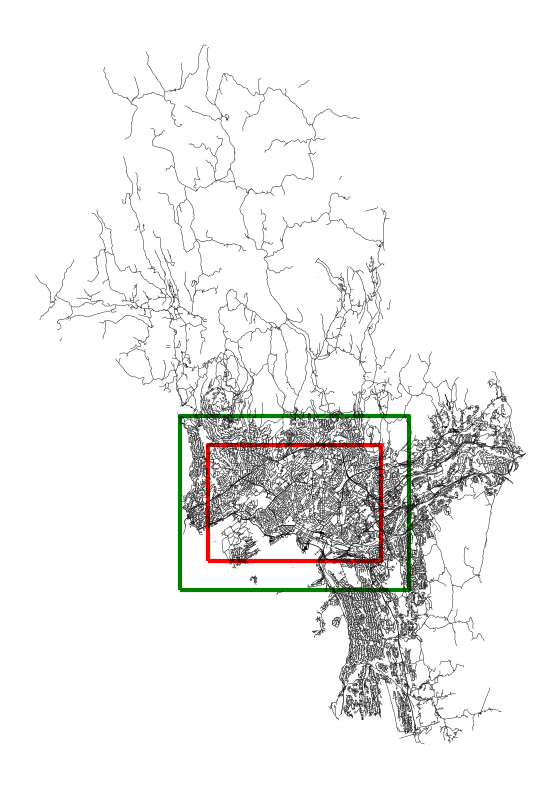

In [7]:
#get oslo without fake oslo's
geo['norway'] = geo['geometry'].apply(lambda x: oslo_bounding.contains(x))
geo = geo[geo['norway']]
#Keep linestrings
geo = geo[~geo['to'].isna()]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()
geo.plot(ax=ax, color='black', zorder = 3, linewidth=0.3)
poly_df_plus.boundary.plot(ax=ax, color='green', zorder = 2, linewidth=3)
poly_df_original.boundary.plot(ax=ax, color='red', zorder = 1, linewidth=3)
plt.savefig('pics/oslo_boxes.png', bbox_inches = 'tight')
plt.show()

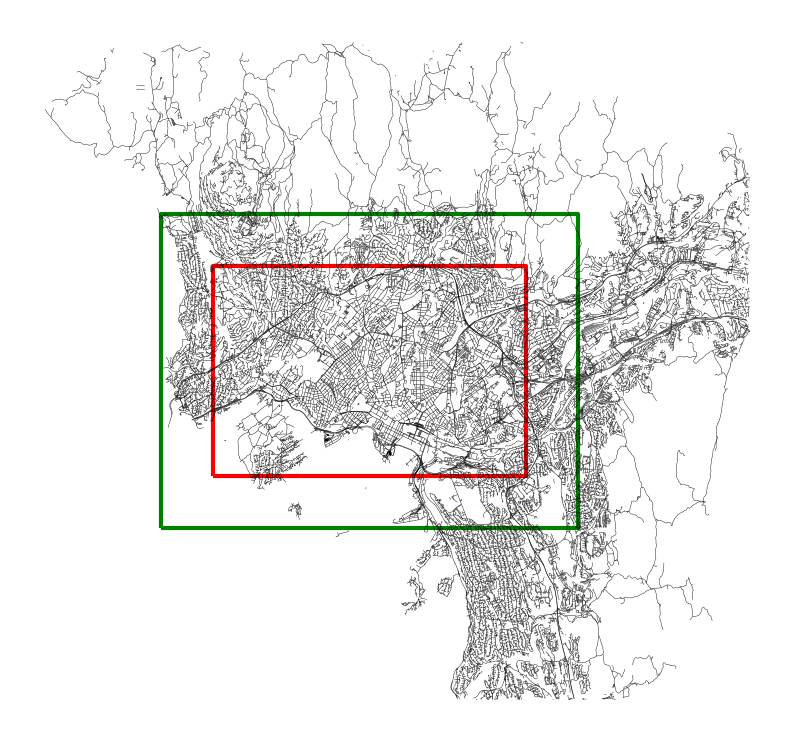

In [8]:
oslo_bounding_close = add_to_bounding(oslo_poly_plus, 10_000)
#get oslo without fake oslo's
geo['norway'] = geo['geometry'].apply(lambda x: oslo_bounding_close.contains(x))
geo = geo[geo['norway']]
#Keep linestrings
geo = geo[~geo['to'].isna()]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()
geo.plot(ax=ax, color='black', zorder = 3, linewidth=0.3)
poly_df_plus.boundary.plot(ax=ax, color='green', zorder = 2, linewidth=3)
poly_df_original.boundary.plot(ax=ax, color='red', zorder = 1, linewidth=3)
plt.savefig('pics/oslo_boxes_close.png', bbox_inches = 'tight')
plt.show()

# Amenities

In [5]:
def get_amenities_stats():
    data = []
    for city in ['Bergen', 'Oslo', 'Portland', 'Trondheim', 'Washington D.C']:
        amenities = load_city_amenities(city, clean= True)
        frm = pyproj.CRS('EPSG:4326')
        to = pyproj.CRS('EPSG:3857')
        project = pyproj.Transformer.from_crs(frm, to, always_xy=True).transform
        amenities['geometry'] = amenities['geometry'].apply(lambda x: transform(project, x))

        #Stats
        types_of_amenities = len(amenities['amenity'].unique())
        number_of_amenities = amenities.shape[0]
        top_three_amenities = amenities['amenity'].value_counts().reset_index().iloc[:3]['amenity'].to_list()
        data.append([city, number_of_amenities, types_of_amenities, top_three_amenities])
    
    return data

In [6]:
amenities_stats = get_amenities_stats()

/Users/malthepabst/Desktop/Research Project/scripts/Graph_func.py:62: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data = pd.read_json(f'data/{city}/{city}_amenities.json')


In [8]:
pd.DataFrame(amenities_stats, columns=['City', '#Amenities', '#Unique', 'Top 3']).to_csv('amenities_stats.csv')

# Front page pic

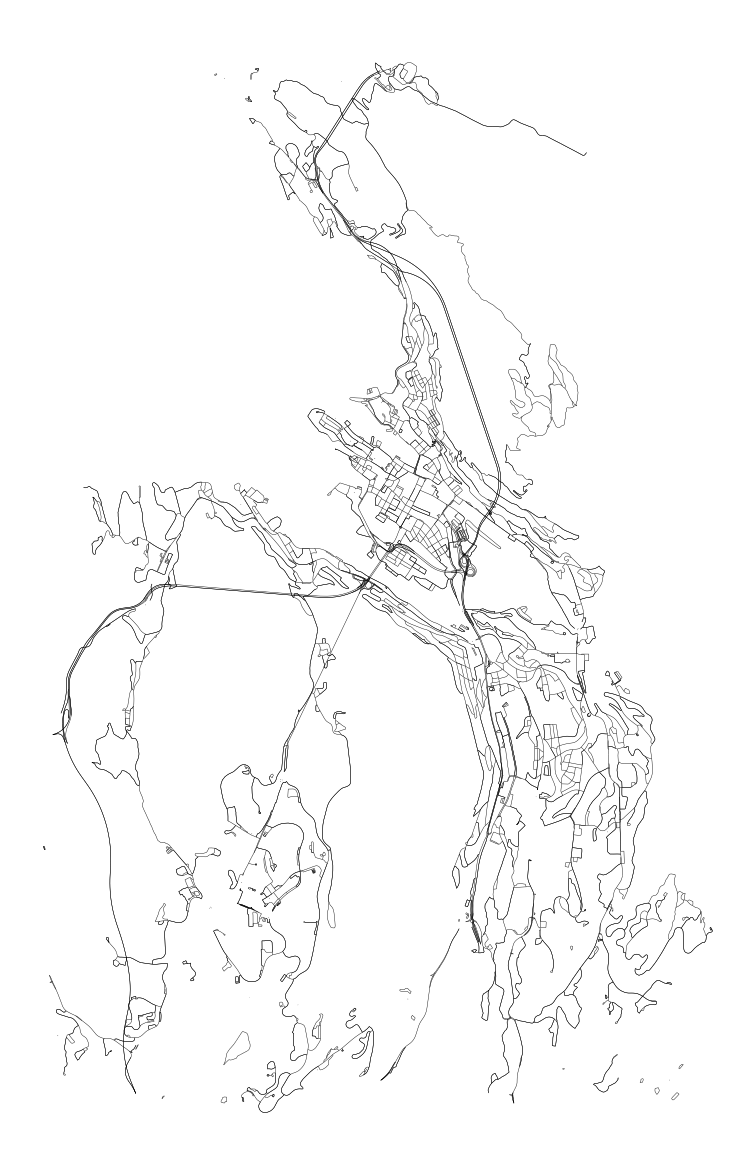

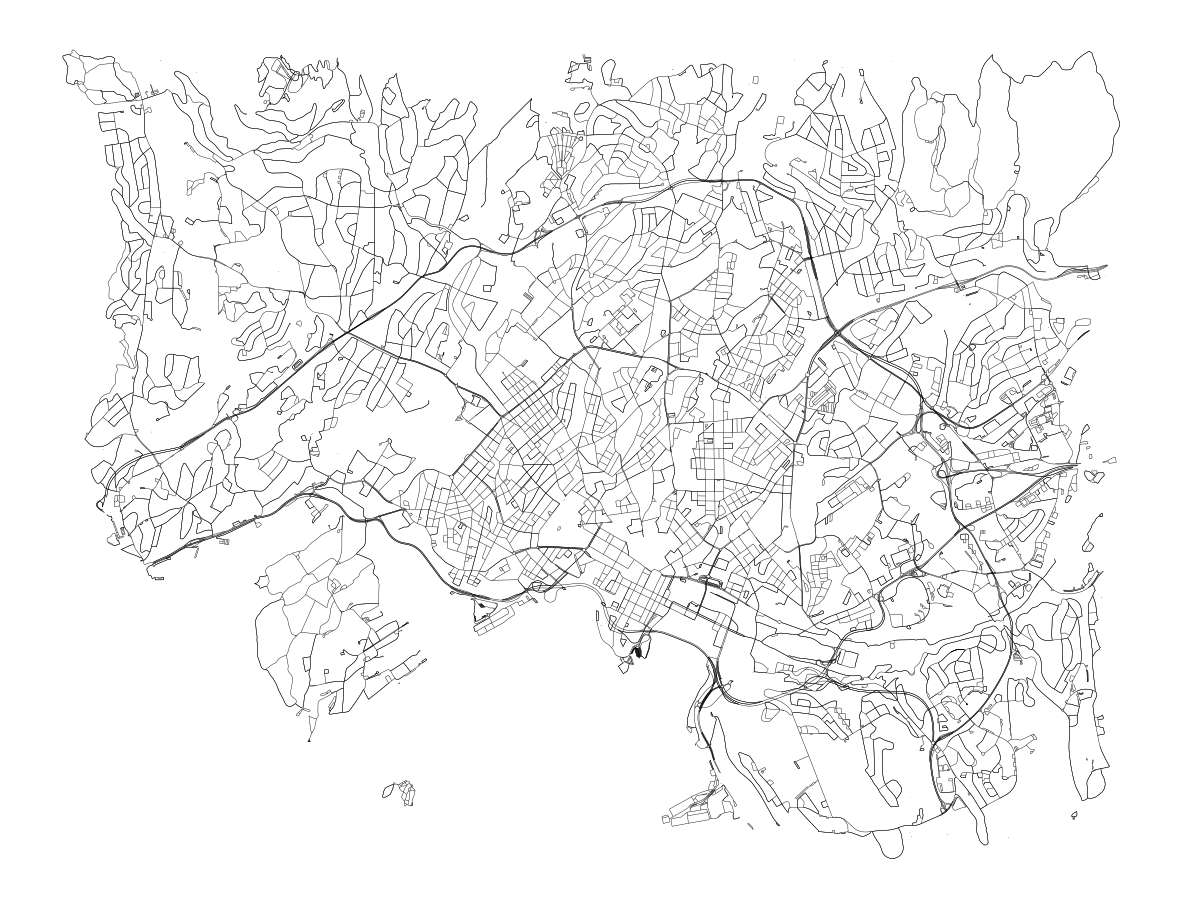

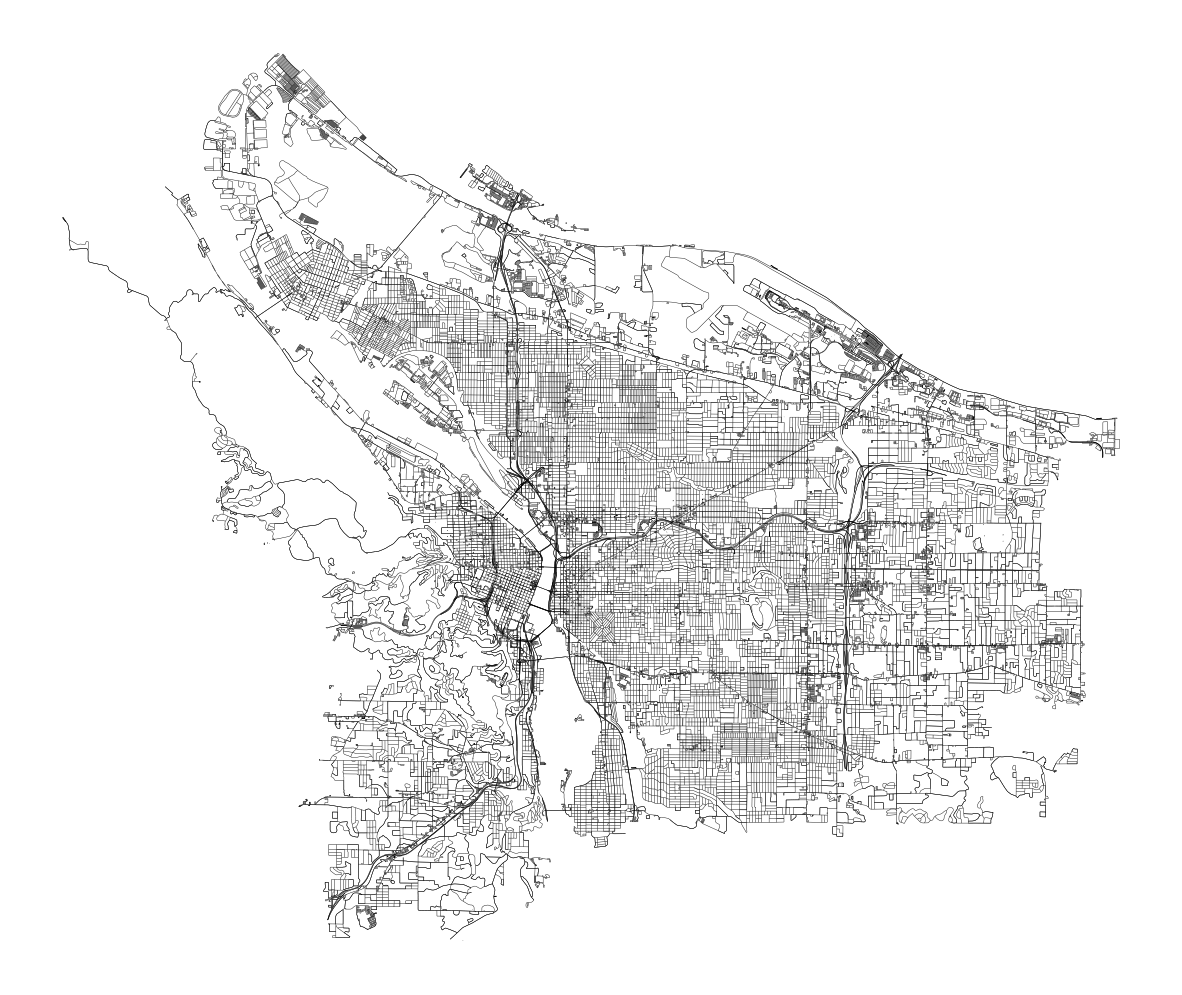

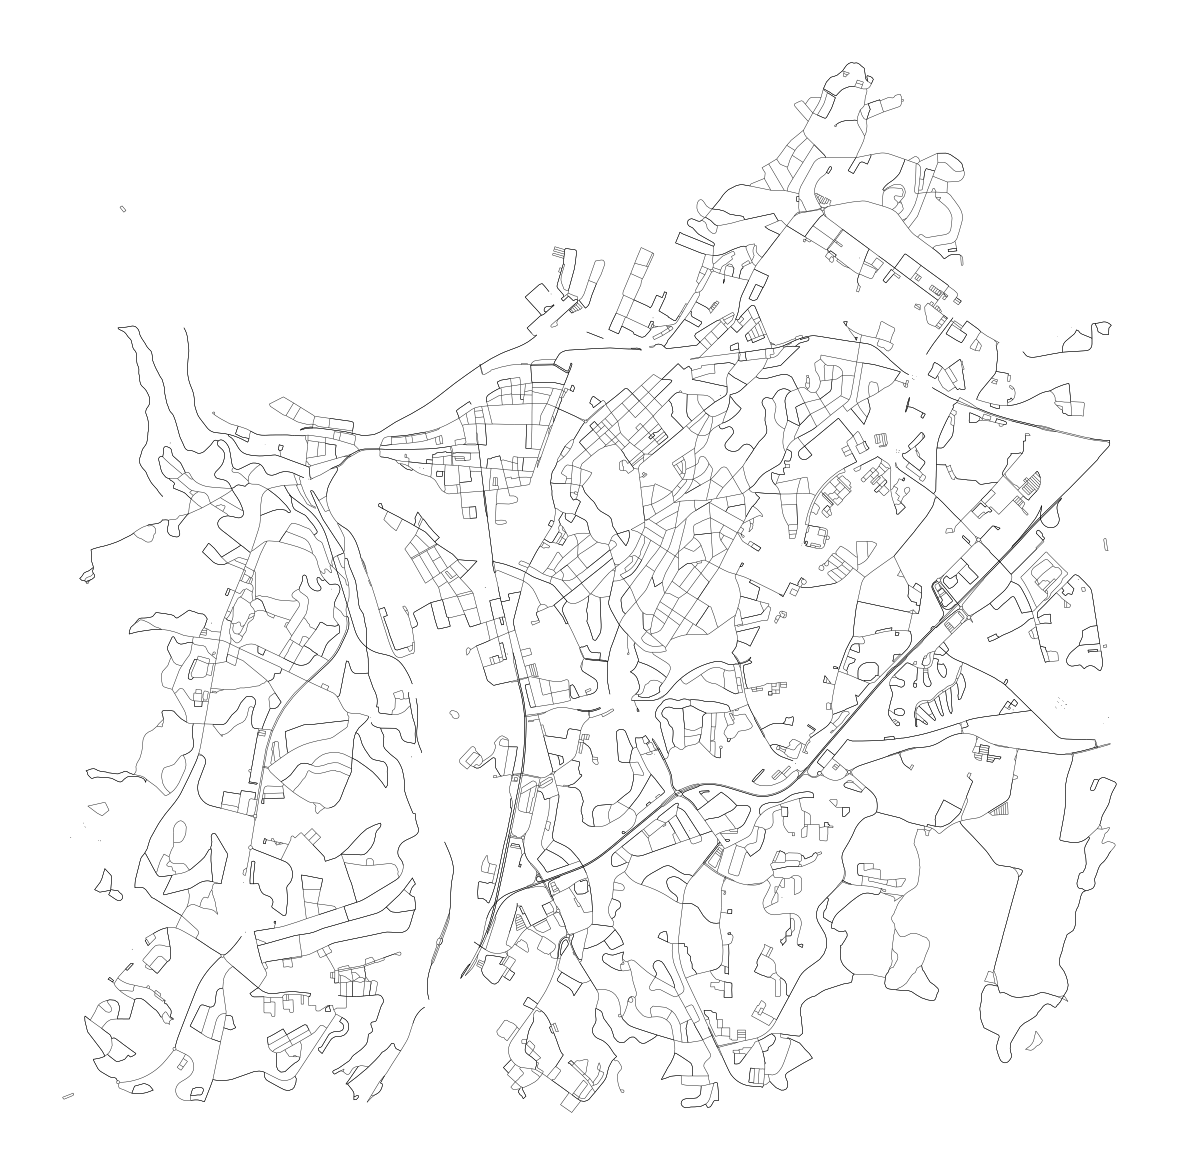

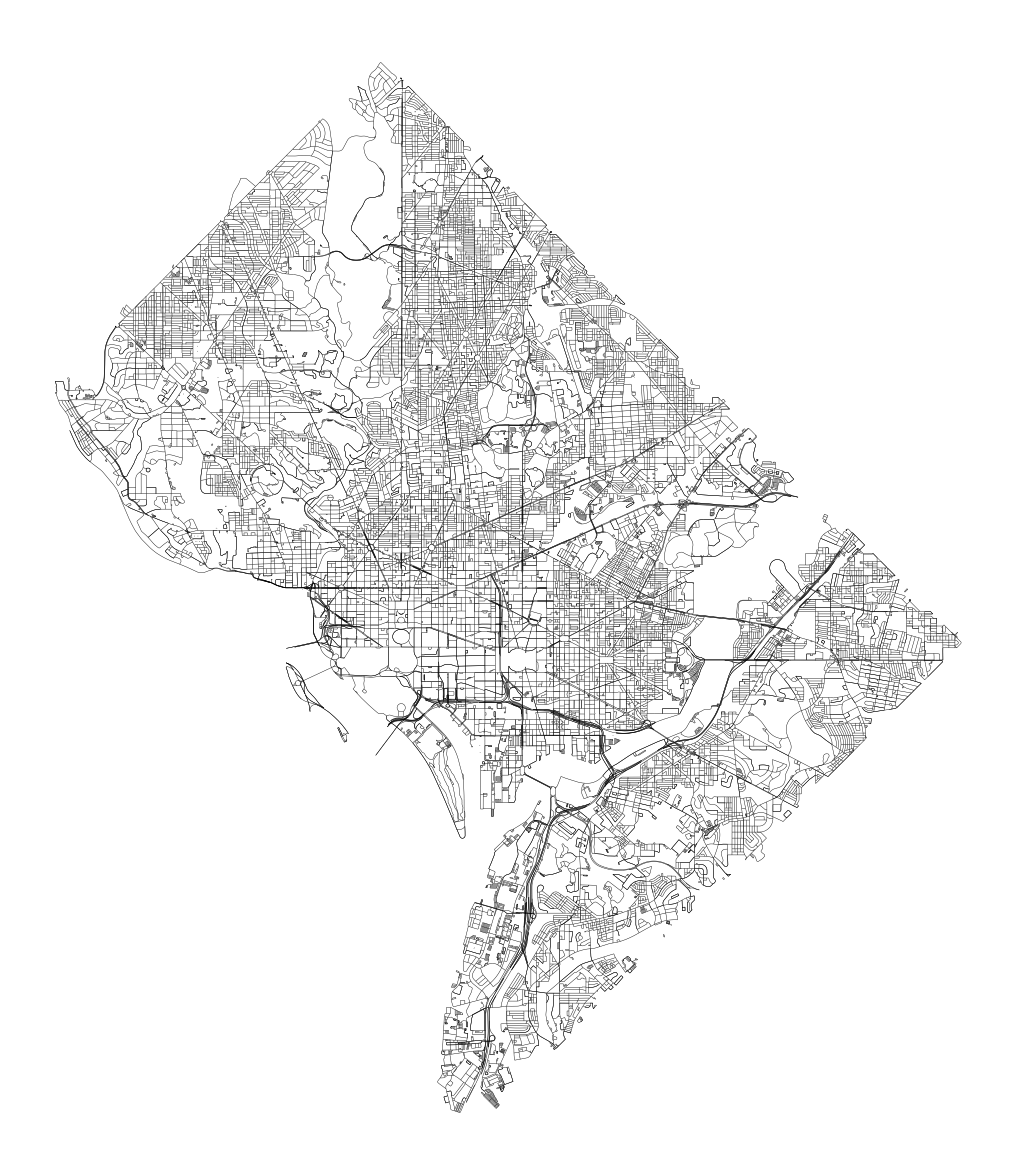

In [21]:
for city in ['Bergen', 'Oslo', 'Portland', 'Trondheim', 'Washington D.C']: 
    G = load_city_graph(city = city, osm_type = 'public_streets', stage = 'deep_clean')
    geo = graph_to_dataframe(G)
    lines = geo[geo['to'].notna()]
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_axis_off()
    lines.plot(ax=ax, color='black', zorder = 0, linewidth=0.3)
    plt.savefig(f'pics/front_page_{city}.png'.lower(), bbox_inches = 'tight')
    plt.show()